In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from image_training_utils import *

# import image_training_utils
# importlib.reload(image_training_utils)
# from image_training_utils import *

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a couple different labels (*povo* and *categoria*) and study how they affect the generated emebdding space.

In [4]:
# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open(row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, povo_name_to_num, povo_num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=vit_transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from transformers import ViTModel

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, _ = get_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:47<00:00,  7.30s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [7]:
# Creating our own ViT classifier (multi-)head for fine-tuning
class ViTClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier1 = nn.Linear(self.vit.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.vit.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
povo_filtered_categories = {}
povo_filtered_categories_names = {}
for c in masks[3][0]:
    povo_filtered_categories[categories_keys[c]] = povo_categories[categories_keys[c]]
    
    povo_filtered_categories_names[povo_num_to_name[categories_keys[c]]] = \
    povo_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            vit_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

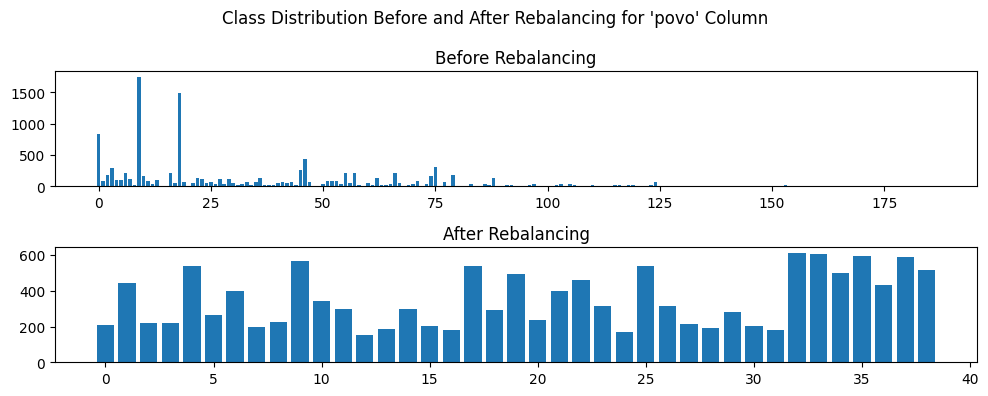

In [10]:
# Plotting old and new class distributions
plot_class_distributions(povo_categories, povo_filtered_categories, labels_minority, \
                         labels_majority, threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
povo_class_weights = compute_class_weights(povo_filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:04<1:17:31, 244.84s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1102.5082, Validation Accuracy: 0.3675


Training model:  10%|████▌                                        | 2/20 [08:12<1:13:52, 246.27s/it]

Best model saved at epoch 2
Epoch 2, Loss: 804.1578, Validation Accuracy: 0.4532


Training model:  15%|██████▊                                      | 3/20 [12:12<1:09:03, 243.75s/it]

Best model saved at epoch 3
Epoch 3, Loss: 614.1215, Validation Accuracy: 0.5123


Training model:  20%|█████████                                    | 4/20 [16:13<1:04:39, 242.45s/it]

Best model saved at epoch 4
Epoch 4, Loss: 459.7856, Validation Accuracy: 0.5626


Training model:  25%|███████████▎                                 | 5/20 [20:13<1:00:27, 241.81s/it]

Best model saved at epoch 5
Epoch 5, Loss: 329.0965, Validation Accuracy: 0.5931


Training model:  30%|██████████████                                 | 6/20 [24:14<56:18, 241.34s/it]

Best model saved at epoch 6
Epoch 6, Loss: 225.0032, Validation Accuracy: 0.6158


Training model:  35%|████████████████▍                              | 7/20 [28:14<52:13, 241.01s/it]

Best model saved at epoch 7
Epoch 7, Loss: 145.5676, Validation Accuracy: 0.6286


Training model:  40%|██████████████████▊                            | 8/20 [32:14<48:08, 240.69s/it]

Best model saved at epoch 8
Epoch 8, Loss: 96.8380, Validation Accuracy: 0.6414


Training model:  45%|█████████████████████▏                         | 9/20 [36:14<44:03, 240.34s/it]

Epoch 9, Loss: 64.4041, Validation Accuracy: 0.6296


Training model:  50%|███████████████████████                       | 10/20 [40:13<40:01, 240.12s/it]

Epoch 10, Loss: 47.5776, Validation Accuracy: 0.6325


Training model:  55%|█████████████████████████▎                    | 11/20 [44:13<35:59, 239.91s/it]

Epoch 11, Loss: 47.7512, Validation Accuracy: 0.6404


Training model:  60%|███████████████████████████▌                  | 12/20 [48:12<31:57, 239.68s/it]

Epoch 12, Loss: 34.2504, Validation Accuracy: 0.6355


Training model:  65%|█████████████████████████████▉                | 13/20 [52:13<27:59, 239.92s/it]

Best model saved at epoch 13
Epoch 13, Loss: 18.8481, Validation Accuracy: 0.6463


Training model:  70%|████████████████████████████████▏             | 14/20 [56:13<24:00, 240.16s/it]

Best model saved at epoch 14
Epoch 14, Loss: 17.7783, Validation Accuracy: 0.6581


Training model:  75%|█████████████████████████████████           | 15/20 [1:00:14<20:01, 240.24s/it]

Best model saved at epoch 15
Epoch 15, Loss: 10.1590, Validation Accuracy: 0.6631


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:04:13<15:59, 239.93s/it]

Epoch 16, Loss: 7.5647, Validation Accuracy: 0.6542


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:08:12<11:59, 239.68s/it]

Epoch 17, Loss: 6.0523, Validation Accuracy: 0.6591


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:12:11<07:58, 239.46s/it]

Epoch 18, Loss: 4.9451, Validation Accuracy: 0.6571


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:16:10<03:59, 239.32s/it]

Epoch 19, Loss: 4.9209, Validation Accuracy: 0.6512


Training model: 100%|████████████████████████████████████████████| 20/20 [1:20:09<00:00, 240.45s/it]

Epoch 20, Loss: 59.1536, Validation Accuracy: 0.6148


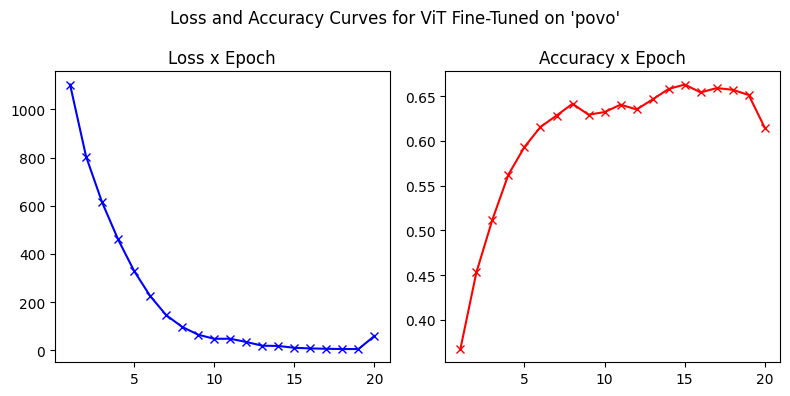

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/image_training_utils.py:686: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('dat

Validation accuracy: 0.6630859375
Validation average per class precision: 0.2690
Validation average per class recall: 0.2523

Test accuracy: 0.6965394616127014
Test average per class precision: 0.2806
Test average per class recall: 0.2643

Test average precision on filtered classes: 0.5825682423817806
Test average recall on filtered classes: 0.5844827451002903


In [12]:
# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=vit_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                         batch_size, epochs, num_classes, model, criterion, \
                                         opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [06:50<2:09:55, 410.31s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1403.2636, Validation Accuracy: 0.4210


Training model:  10%|████▌                                        | 2/20 [13:51<2:04:59, 416.63s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1072.2561, Validation Accuracy: 0.5493


Training model:  15%|██████▊                                      | 3/20 [20:46<1:57:53, 416.08s/it]

Best model saved at epoch 3
Epoch 3, Loss: 759.5104, Validation Accuracy: 0.6197


Training model:  20%|█████████                                    | 4/20 [27:39<1:50:35, 414.73s/it]

Best model saved at epoch 4
Epoch 4, Loss: 461.7475, Validation Accuracy: 0.6729


Training model:  25%|███████████▎                                 | 5/20 [34:32<1:43:33, 414.25s/it]

Best model saved at epoch 5
Epoch 5, Loss: 236.7909, Validation Accuracy: 0.6901


Training model:  30%|█████████████▌                               | 6/20 [41:24<1:36:25, 413.27s/it]

Best model saved at epoch 6
Epoch 6, Loss: 114.8428, Validation Accuracy: 0.6917


Training model:  35%|███████████████▋                             | 7/20 [48:18<1:29:37, 413.69s/it]

Best model saved at epoch 7
Epoch 7, Loss: 61.0521, Validation Accuracy: 0.7089


Training model:  40%|██████████████████                           | 8/20 [55:10<1:22:35, 412.97s/it]

Epoch 8, Loss: 37.7491, Validation Accuracy: 0.7089


Training model:  45%|███████████████████▎                       | 9/20 [1:01:59<1:15:28, 411.73s/it]

Epoch 9, Loss: 29.8905, Validation Accuracy: 0.6901


Training model:  50%|█████████████████████                     | 10/20 [1:08:51<1:08:39, 411.93s/it]

Epoch 10, Loss: 19.8729, Validation Accuracy: 0.6964


Training model:  55%|███████████████████████                   | 11/20 [1:15:41<1:01:41, 411.32s/it]

Epoch 11, Loss: 17.3425, Validation Accuracy: 0.7074


Training model:  55%|███████████████████████                   | 11/20 [1:22:32<1:07:32, 450.24s/it]

Early-stopping training!


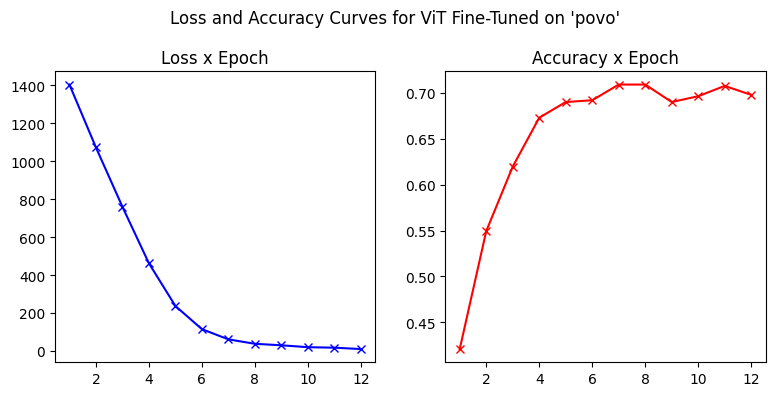

Validation accuracy: 0.708984375
Validation average per class precision: 0.7041
Validation average per class recall: 0.6806

Test accuracy: 0.6951219439506531
Test average per class precision: 0.6780
Test average per class recall: 0.6390



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:46<00:00,  7.26s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:45<1:49:23, 345.44s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1437.8905, Validation Accuracy: 0.3959


Training model:  10%|████▌                                        | 2/20 [11:21<1:42:00, 340.04s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1162.7835, Validation Accuracy: 0.5086


Training model:  15%|██████▊                                      | 3/20 [16:59<1:36:00, 338.83s/it]

Best model saved at epoch 3
Epoch 3, Loss: 900.6506, Validation Accuracy: 0.5743


Training model:  20%|█████████                                    | 4/20 [22:36<1:30:10, 338.16s/it]

Best model saved at epoch 4
Epoch 4, Loss: 636.9210, Validation Accuracy: 0.6479


Training model:  25%|███████████▎                                 | 5/20 [28:09<1:24:05, 336.36s/it]

Best model saved at epoch 5
Epoch 5, Loss: 392.5877, Validation Accuracy: 0.6886


Training model:  30%|█████████████▌                               | 6/20 [33:43<1:18:17, 335.56s/it]

Best model saved at epoch 6
Epoch 6, Loss: 211.6819, Validation Accuracy: 0.7011


Training model:  35%|███████████████▋                             | 7/20 [39:14<1:12:24, 334.21s/it]

Best model saved at epoch 7
Epoch 7, Loss: 107.3599, Validation Accuracy: 0.7152


Training model:  40%|██████████████████                           | 8/20 [44:48<1:06:49, 334.11s/it]

Epoch 8, Loss: 58.3603, Validation Accuracy: 0.7136


Training model:  45%|████████████████████▎                        | 9/20 [50:20<1:01:07, 333.40s/it]

Epoch 9, Loss: 35.7921, Validation Accuracy: 0.7089


Training model:  50%|███████████████████████                       | 10/20 [55:52<55:30, 333.00s/it]

Epoch 10, Loss: 23.3909, Validation Accuracy: 0.7105


Training model:  55%|████████████████████████▏                   | 11/20 [1:01:27<50:00, 333.44s/it]

Epoch 11, Loss: 17.9901, Validation Accuracy: 0.7058


Training model:  60%|██████████████████████████▍                 | 12/20 [1:06:57<44:19, 332.45s/it]

Epoch 12, Loss: 12.1216, Validation Accuracy: 0.7121


Training model:  65%|████████████████████████████▌               | 13/20 [1:12:31<38:51, 333.06s/it]

Best model saved at epoch 13
Epoch 13, Loss: 11.0496, Validation Accuracy: 0.7167


Training model:  70%|██████████████████████████████▊             | 14/20 [1:18:05<33:19, 333.32s/it]

Epoch 14, Loss: 8.7717, Validation Accuracy: 0.7074


Training model:  75%|█████████████████████████████████           | 15/20 [1:23:38<27:46, 333.24s/it]

Epoch 15, Loss: 5.6630, Validation Accuracy: 0.7121


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:29:13<22:14, 333.71s/it]

Epoch 16, Loss: 6.0306, Validation Accuracy: 0.7105


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:34:45<16:39, 333.04s/it]

Epoch 17, Loss: 4.4782, Validation Accuracy: 0.6980


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:40:16<11:05, 332.67s/it]

Epoch 18, Loss: 4.0747, Validation Accuracy: 0.7089


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:45:51<05:33, 333.20s/it]

Epoch 19, Loss: 3.1801, Validation Accuracy: 0.7152


Training model: 100%|████████████████████████████████████████████| 20/20 [1:51:24<00:00, 334.22s/it]

Epoch 20, Loss: 2.6742, Validation Accuracy: 0.7152


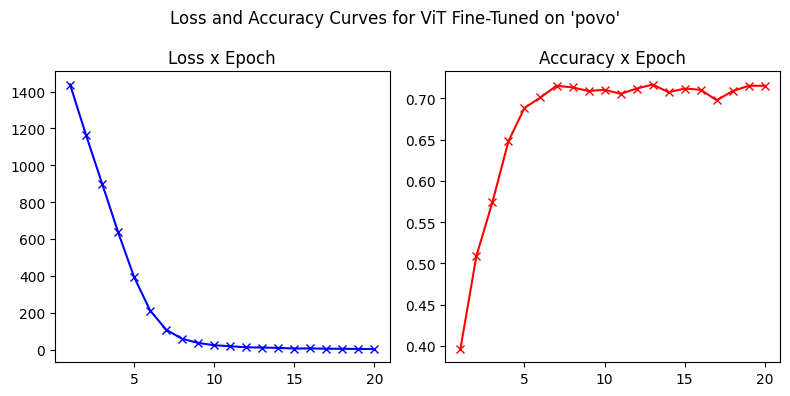

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/image_training_utils.py:686: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('dat

Validation accuracy: 0.716796875
Validation average per class precision: 0.7060
Validation average per class recall: 0.6826

Test accuracy: 0.693379819393158
Test average per class precision: 0.7042
Test average per class recall: 0.6568



In [14]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [15]:
# Now rebalancing the 'categoria' column
categoria_labels, categoria_name_to_num, categoria_num_to_name = \
preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=vit_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categoria_categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [categoria_name_to_num['etnobotânica']]
categoria_filtered_categories = {}
categoria_filtered_categories_names = {}
for c in set(categoria_name_to_num.values()) - set(filter_out):
    categoria_filtered_categories[categories_keys[c]] = \
    categoria_categories[categories_keys[c]]
    
    categoria_filtered_categories_names[categoria_num_to_name[categories_keys[c]]] = \
    categoria_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [16]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, vit_transform, \
                               threshold_multiplier, 'categoria')

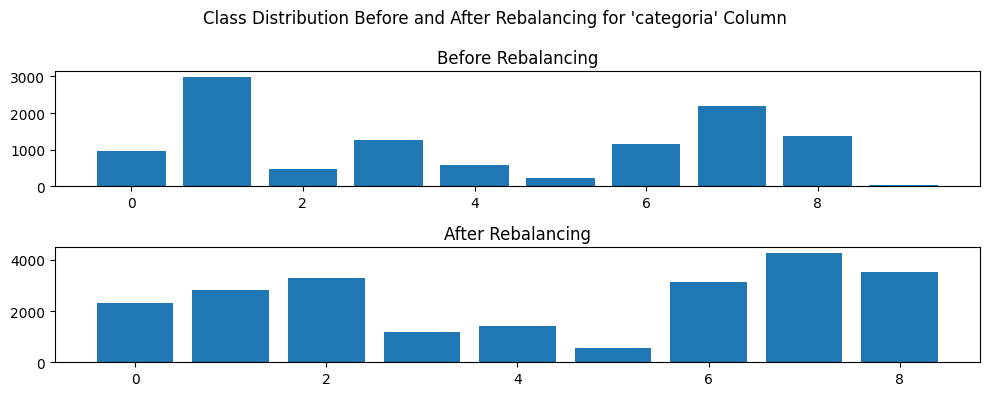

In [17]:
# Plotting old and new class distributions
plot_class_distributions(categoria_categories, categoria_filtered_categories, \
                         labels_minority, labels_majority, threshold_multiplier, 'categoria')

In [18]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
categoria_class_weights = compute_class_weights(categoria_filtered_categories, \
                                                labels_minority, labels_majority, device, \
                                                threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:05<1:17:49, 245.74s/it]

Best model saved at epoch 1
Epoch 1, Loss: 475.9322, Validation Accuracy: 0.6227


Training model:  10%|████▌                                        | 2/20 [08:05<1:12:38, 242.15s/it]

Best model saved at epoch 2
Epoch 2, Loss: 292.6423, Validation Accuracy: 0.7803


Training model:  15%|██████▊                                      | 3/20 [12:05<1:08:17, 241.00s/it]

Best model saved at epoch 3
Epoch 3, Loss: 204.8001, Validation Accuracy: 0.8315


Training model:  20%|█████████                                    | 4/20 [16:05<1:04:10, 240.65s/it]

Best model saved at epoch 4
Epoch 4, Loss: 144.2569, Validation Accuracy: 0.8463


Training model:  25%|███████████▎                                 | 5/20 [20:04<1:00:03, 240.21s/it]

Best model saved at epoch 5
Epoch 5, Loss: 102.6044, Validation Accuracy: 0.8473


Training model:  30%|██████████████                                 | 6/20 [24:04<56:02, 240.16s/it]

Best model saved at epoch 6
Epoch 6, Loss: 75.1638, Validation Accuracy: 0.8483


Training model:  35%|████████████████▍                              | 7/20 [28:04<51:59, 239.94s/it]

Best model saved at epoch 7
Epoch 7, Loss: 55.2753, Validation Accuracy: 0.8591


Training model:  40%|██████████████████▊                            | 8/20 [32:03<47:58, 239.88s/it]

Best model saved at epoch 8
Epoch 8, Loss: 40.3375, Validation Accuracy: 0.8759


Training model:  45%|█████████████████████▏                         | 9/20 [36:02<43:54, 239.54s/it]

Epoch 9, Loss: 32.3253, Validation Accuracy: 0.8650


Training model:  50%|███████████████████████                       | 10/20 [40:02<39:56, 239.69s/it]

Best model saved at epoch 10
Epoch 10, Loss: 25.2882, Validation Accuracy: 0.8768


Training model:  55%|█████████████████████████▎                    | 11/20 [44:01<35:53, 239.31s/it]

Epoch 11, Loss: 19.7849, Validation Accuracy: 0.8680


Training model:  60%|███████████████████████████▌                  | 12/20 [47:59<31:52, 239.01s/it]

Epoch 12, Loss: 19.8727, Validation Accuracy: 0.8601


Training model:  65%|█████████████████████████████▉                | 13/20 [51:57<27:52, 238.87s/it]

Epoch 13, Loss: 15.1181, Validation Accuracy: 0.8650


Training model:  65%|█████████████████████████████▉                | 13/20 [55:56<30:07, 258.19s/it]

Early-stopping training!


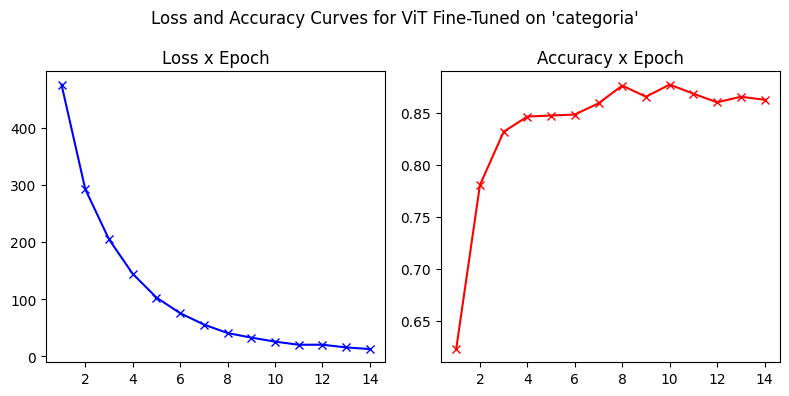

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/image_training_utils.py:686: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('dat

Validation accuracy: 0.876953125
Validation average per class precision: 0.7773
Validation average per class recall: 0.7551

Test accuracy: 0.8828749060630798
Test average per class precision: 0.7780
Test average per class recall: 0.7749

Test average precision on filtered classes: 0.8644700315263536
Test average recall on filtered classes: 0.8609554171562195


In [19]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=vit_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [11:41<3:42:14, 701.84s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2452.0667, Validation Accuracy: 0.6881


Training model:  10%|████▌                                        | 2/20 [23:24<3:30:38, 702.12s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1457.2488, Validation Accuracy: 0.7755


Training model:  15%|██████▊                                      | 3/20 [34:47<3:16:26, 693.33s/it]

Best model saved at epoch 3
Epoch 3, Loss: 978.2213, Validation Accuracy: 0.8289


Training model:  20%|█████████                                    | 4/20 [46:07<3:03:30, 688.15s/it]

Best model saved at epoch 4
Epoch 4, Loss: 674.1345, Validation Accuracy: 0.8620


Training model:  25%|███████████▎                                 | 5/20 [57:26<2:51:11, 684.78s/it]

Epoch 5, Loss: 464.3924, Validation Accuracy: 0.8620


Training model:  30%|████████████▉                              | 6/20 [1:08:47<2:39:31, 683.66s/it]

Best model saved at epoch 6
Epoch 6, Loss: 320.1958, Validation Accuracy: 0.8684


Training model:  35%|███████████████                            | 7/20 [1:20:07<2:27:51, 682.45s/it]

Best model saved at epoch 7
Epoch 7, Loss: 220.6246, Validation Accuracy: 0.8703


Training model:  40%|█████████████████▏                         | 8/20 [1:31:27<2:16:20, 681.74s/it]

Best model saved at epoch 8
Epoch 8, Loss: 155.3682, Validation Accuracy: 0.8767


Training model:  45%|███████████████████▎                       | 9/20 [1:42:47<2:04:52, 681.10s/it]

Best model saved at epoch 9
Epoch 9, Loss: 112.6785, Validation Accuracy: 0.8813


Training model:  50%|█████████████████████                     | 10/20 [1:54:09<1:53:34, 681.40s/it]

Epoch 10, Loss: 84.5284, Validation Accuracy: 0.8721


Training model:  55%|███████████████████████                   | 11/20 [2:05:29<1:42:09, 681.03s/it]

Best model saved at epoch 11
Epoch 11, Loss: 65.2910, Validation Accuracy: 0.8822


Training model:  60%|█████████████████████████▏                | 12/20 [2:16:52<1:30:53, 681.73s/it]

Epoch 12, Loss: 51.7154, Validation Accuracy: 0.8721


Training model:  65%|███████████████████████████▎              | 13/20 [2:28:22<1:19:48, 684.03s/it]

Epoch 13, Loss: 43.3617, Validation Accuracy: 0.8786


Training model:  70%|█████████████████████████████▍            | 14/20 [2:39:45<1:08:22, 683.71s/it]

Epoch 14, Loss: 34.0964, Validation Accuracy: 0.8776


Training model:  75%|█████████████████████████████████           | 15/20 [2:51:05<56:53, 682.76s/it]

Epoch 15, Loss: 32.1411, Validation Accuracy: 0.8703


Training model:  75%|███████████████████████████████▌          | 15/20 [3:02:22<1:00:47, 729.48s/it]


Early-stopping training!


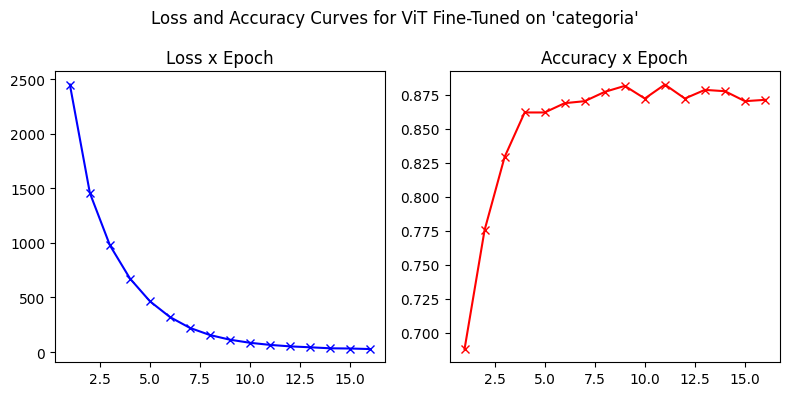

Validation accuracy: 0.88232421875
Validation average per class precision: 0.8783
Validation average per class recall: 0.8488

Test accuracy: 0.8752556443214417
Test average per class precision: 0.8861
Test average per class recall: 0.8341



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:45<00:00,  7.20s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [08:53<2:48:52, 533.31s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2681.4554, Validation Accuracy: 0.6624


Training model:  10%|████▌                                        | 2/20 [17:45<2:39:52, 532.94s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1802.3919, Validation Accuracy: 0.7305


Training model:  15%|██████▊                                      | 3/20 [26:38<2:30:59, 532.93s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1291.3649, Validation Accuracy: 0.7737


Training model:  20%|█████████                                    | 4/20 [35:36<2:22:38, 534.90s/it]

Best model saved at epoch 4
Epoch 4, Loss: 973.2874, Validation Accuracy: 0.8224


Training model:  25%|███████████▎                                 | 5/20 [44:26<2:13:15, 533.04s/it]

Best model saved at epoch 5
Epoch 5, Loss: 740.7311, Validation Accuracy: 0.8482


Training model:  30%|█████████████▌                               | 6/20 [53:23<2:04:41, 534.40s/it]

Best model saved at epoch 6
Epoch 6, Loss: 560.2785, Validation Accuracy: 0.8602


Training model:  35%|███████████████                            | 7/20 [1:02:17<1:55:45, 534.31s/it]

Best model saved at epoch 7
Epoch 7, Loss: 419.0418, Validation Accuracy: 0.8712


Training model:  40%|█████████████████▏                         | 8/20 [1:11:08<1:46:38, 533.18s/it]

Best model saved at epoch 8
Epoch 8, Loss: 306.9795, Validation Accuracy: 0.8832


Training model:  45%|███████████████████▎                       | 9/20 [1:20:03<1:37:51, 533.77s/it]

Best model saved at epoch 9
Epoch 9, Loss: 224.8309, Validation Accuracy: 0.8859


Training model:  50%|█████████████████████                     | 10/20 [1:28:57<1:28:56, 533.68s/it]

Epoch 10, Loss: 161.5754, Validation Accuracy: 0.8795


Training model:  55%|███████████████████████                   | 11/20 [1:37:51<1:20:04, 533.83s/it]

Epoch 11, Loss: 113.6131, Validation Accuracy: 0.8813


Training model:  60%|█████████████████████████▏                | 12/20 [1:46:46<1:11:14, 534.36s/it]

Epoch 12, Loss: 81.7280, Validation Accuracy: 0.8859


Training model:  65%|███████████████████████████▎              | 13/20 [1:55:43<1:02:25, 535.02s/it]

Best model saved at epoch 13
Epoch 13, Loss: 57.8023, Validation Accuracy: 0.8868


Training model:  70%|██████████████████████████████▊             | 14/20 [2:04:38<53:30, 535.14s/it]

Best model saved at epoch 14
Epoch 14, Loss: 42.8885, Validation Accuracy: 0.8878


Training model:  75%|█████████████████████████████████           | 15/20 [2:13:33<44:35, 535.11s/it]

Best model saved at epoch 15
Epoch 15, Loss: 29.2765, Validation Accuracy: 0.8905


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:22:28<35:40, 535.07s/it]

Epoch 16, Loss: 21.8985, Validation Accuracy: 0.8887


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:31:21<26:42, 534.26s/it]

Epoch 17, Loss: 18.0227, Validation Accuracy: 0.8859


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:40:11<17:46, 533.13s/it]

Epoch 18, Loss: 13.2742, Validation Accuracy: 0.8905


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:49:04<08:53, 533.12s/it]

Epoch 19, Loss: 11.9967, Validation Accuracy: 0.8905


Training model: 100%|████████████████████████████████████████████| 20/20 [2:57:56<00:00, 533.82s/it]

Epoch 20, Loss: 9.6512, Validation Accuracy: 0.8859


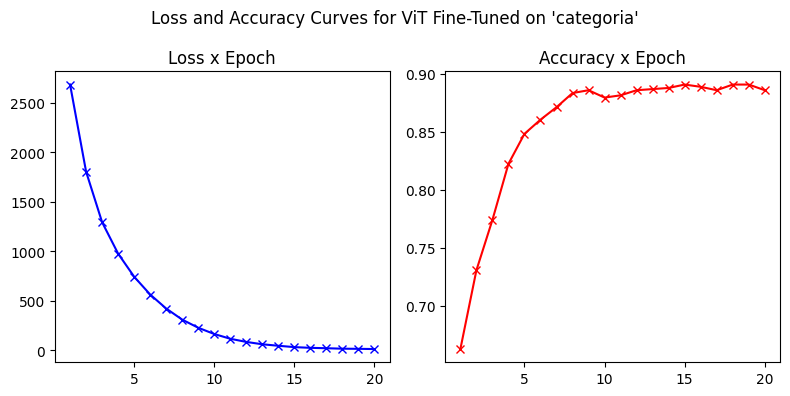

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/image_training_utils.py:686: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('dat

Validation accuracy: 0.890625
Validation average per class precision: 0.8825
Validation average per class recall: 0.8758

Test accuracy: 0.8834356069564819
Test average per class precision: 0.8708
Test average per class recall: 0.8573



In [21]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'frozen_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

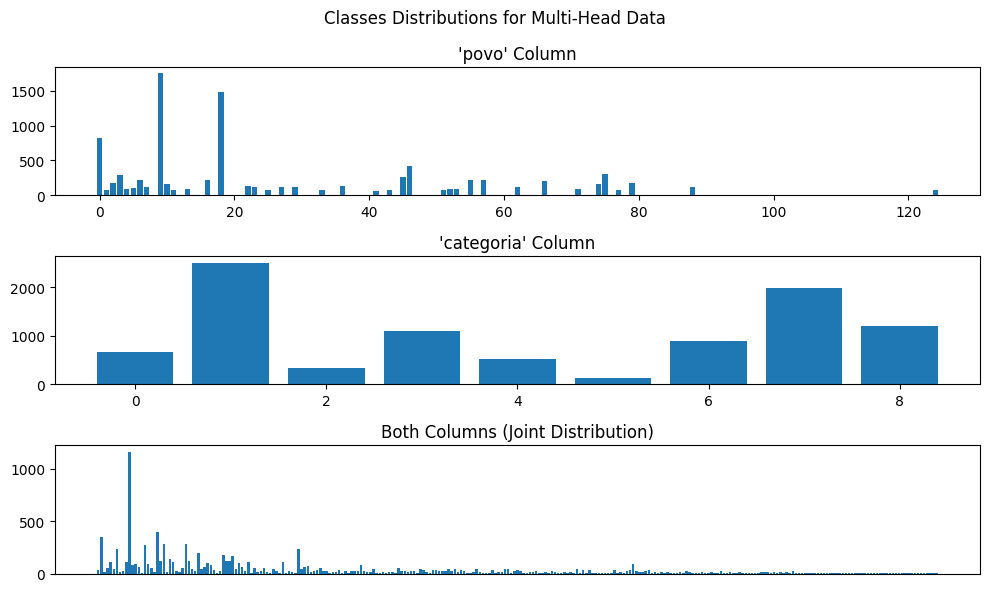

In [22]:
# Getting data that passes both heads' data-filters
povo_set = set(np.array(list(povo_labels.keys()))\
                [np.where(np.isin(np.array(list(povo_labels.values())), \
                np.array(list(povo_filtered_categories.keys()))))[0]])
categoria_set = set(np.array(list(categoria_labels.keys()))\
                    [np.where(np.isin(np.array(list(categoria_labels.values())), \
                    np.array(list(categoria_filtered_categories.keys()))))[0]])
multi_head_keys = [str(x) for x in povo_set.intersection(categoria_set)]

# Studying individual and joint classes' distributions
povo_freq = {}
categoria_freq = {}
multi_freq = {}
for key in multi_head_keys:
    try:
        povo_freq[povo_labels[key]] += 1
    except:
        povo_freq[povo_labels[key]] = 1

    try:
        categoria_freq[categoria_labels[key]] += 1
    except:
        categoria_freq[categoria_labels[key]] = 1

    try:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] += 1
    except:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] = 1

# Utility function to plot rows on data distribution plot
def row_bar_plot(col_freq, name, row, rows=3, cols=1, remove_xticks=False):
    plt.subplot(rows, cols, row)
    plt.bar(list(col_freq.keys()), list(col_freq.values()))
    plt.title(name)

    if remove_xticks:
        plt.xlabel("")
        plt.xticks([])

plt.figure(figsize=(10,6))
plt.suptitle('Classes Distributions for Multi-Head Data')

row_bar_plot(povo_freq, "'povo' Column", 1)
row_bar_plot(categoria_freq, "'categoria' Column", 2)
row_bar_plot(multi_freq, "Both Columns (Joint Distribution)", 3, remove_xticks=True)

plt.tight_layout()
plt.show()

In [23]:
# Because of the even worse degree of unbalanced data on the joint distribution, we balance
# the dataset taking the 'povo' column into consideration and study the new joint distribution
multi_povo_labels = {}
multi_categoria_labels = {}
for key in multi_head_keys:
    multi_povo_labels[key] = povo_labels[key]
    multi_categoria_labels[key] = categoria_labels[key]

# Reusing previous dataset infrastructure to build multi-label dataset
multi_povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_povo_labels)
multi_povo_filtered_categories = multi_povo_categories
multi_povo_filtered_categories_names = {}
for c in categories_keys:
    multi_povo_filtered_categories_names[povo_num_to_name[c]] = multi_povo_categories[c]

multi_categoria_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_categoria_labels)
multi_categoria_filtered_categories = multi_categoria_categories
multi_categoria_filtered_categories_names = {}
for c in categories_keys:
    multi_categoria_filtered_categories_names[categoria_num_to_name[c]] = \
    multi_categoria_categories[c]

Quantile X Data Percentage:
Q-10: 75.00, 96.14% of data
Q-25: 86.00, 91.77% of data
Q-50: 123.00, 80.30% of data
Q-75: 216.50, 64.05% of data
Q-90: 327.40, 47.86% of data

Quantile X Data Percentage:
Q-10: 302.40, 98.63% of data
Q-25: 515.00, 89.42% of data
Q-50: 887.00, 72.71% of data
Q-75: 1203.00, 48.06% of data
Q-90: 2089.00, 26.84% of data



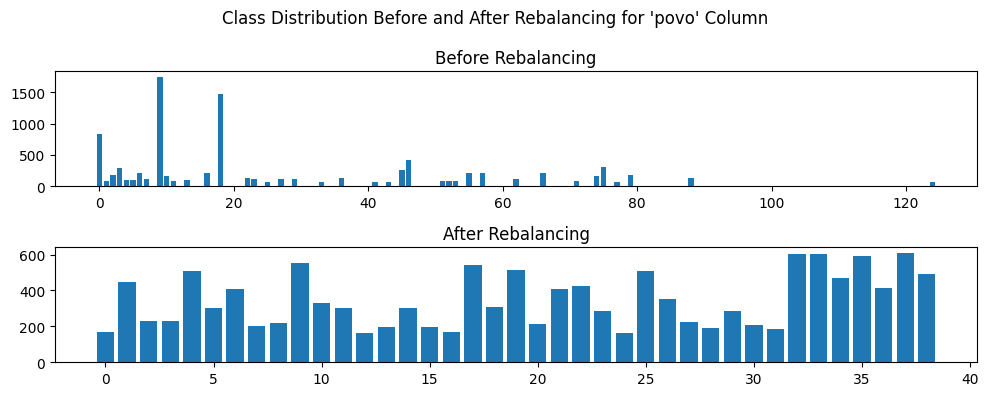

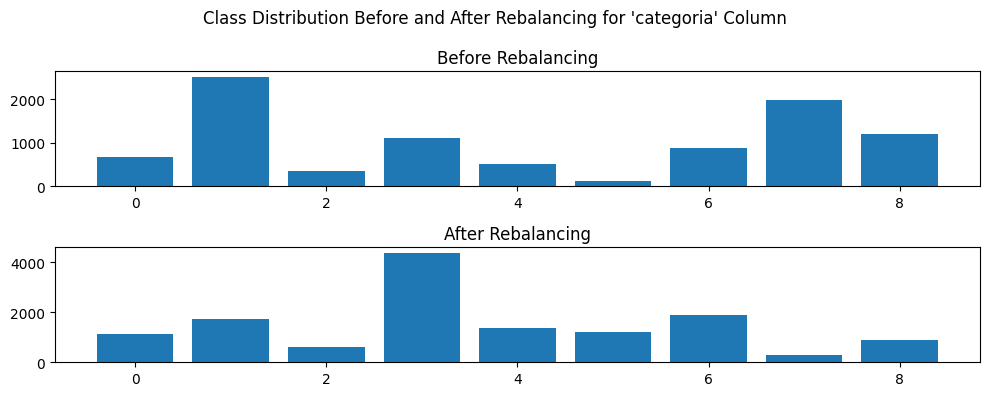

In [24]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         vit_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

# Plotting old and new class distributions
multihead_plot_class_distributions(multi_povo_categories, multi_povo_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'povo')

multihead_plot_class_distributions(multi_categoria_categories, \
                                   multi_categoria_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'categoria')

In [25]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

Training model:   5%|██▎                                          | 1/20 [07:06<2:15:02, 426.45s/it]

Best model saved at epoch 1
Epoch 1, Combined Loss: 2388.3206, Validation Average Accuracy: 0.3984


Training model:  10%|████▌                                        | 2/20 [14:12<2:07:47, 425.95s/it]

Best model saved at epoch 2
Epoch 2, Combined Loss: 2134.8453, Validation Average Accuracy: 0.4810


Training model:  15%|██████▊                                      | 3/20 [21:07<1:59:20, 421.23s/it]

Best model saved at epoch 3
Epoch 3, Combined Loss: 1923.1520, Validation Average Accuracy: 0.5229


Training model:  20%|█████████                                    | 4/20 [28:00<1:51:28, 418.04s/it]

Best model saved at epoch 4
Epoch 4, Combined Loss: 1771.9360, Validation Average Accuracy: 0.5400


Training model:  25%|███████████▎                                 | 5/20 [34:56<1:44:15, 417.06s/it]

Best model saved at epoch 5
Epoch 5, Combined Loss: 1652.2009, Validation Average Accuracy: 0.5708


Training model:  30%|█████████████▌                               | 6/20 [41:49<1:37:01, 415.82s/it]

Best model saved at epoch 6
Epoch 6, Combined Loss: 1550.8979, Validation Average Accuracy: 0.5796


Training model:  35%|███████████████▋                             | 7/20 [48:46<1:30:10, 416.20s/it]

Best model saved at epoch 7
Epoch 7, Combined Loss: 1462.2200, Validation Average Accuracy: 0.6035


Training model:  40%|██████████████████                           | 8/20 [55:41<1:23:10, 415.91s/it]

Best model saved at epoch 8
Epoch 8, Combined Loss: 1382.0907, Validation Average Accuracy: 0.6152


Training model:  45%|███████████████████▎                       | 9/20 [1:02:37<1:16:15, 415.97s/it]

Best model saved at epoch 9
Epoch 9, Combined Loss: 1308.1671, Validation Average Accuracy: 0.6357


Training model:  50%|█████████████████████                     | 10/20 [1:09:34<1:09:21, 416.19s/it]

Best model saved at epoch 10
Epoch 10, Combined Loss: 1238.7455, Validation Average Accuracy: 0.6445


Training model:  55%|███████████████████████                   | 11/20 [1:16:29<1:02:23, 415.94s/it]

Best model saved at epoch 11
Epoch 11, Combined Loss: 1171.5837, Validation Average Accuracy: 0.6680


Training model:  60%|██████████████████████████▍                 | 12/20 [1:23:23<55:21, 415.15s/it]

Best model saved at epoch 12
Epoch 12, Combined Loss: 1107.2464, Validation Average Accuracy: 0.6777


Training model:  65%|████████████████████████████▌               | 13/20 [1:30:16<48:21, 414.43s/it]

Best model saved at epoch 13
Epoch 13, Combined Loss: 1042.0297, Validation Average Accuracy: 0.6885


Training model:  70%|██████████████████████████████▊             | 14/20 [1:37:08<41:23, 413.96s/it]

Best model saved at epoch 14
Epoch 14, Combined Loss: 980.2263, Validation Average Accuracy: 0.7041


Training model:  75%|█████████████████████████████████           | 15/20 [1:44:03<34:31, 414.28s/it]

Best model saved at epoch 15
Epoch 15, Combined Loss: 917.2301, Validation Average Accuracy: 0.7100


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:50:59<27:38, 414.59s/it]

Best model saved at epoch 16
Epoch 16, Combined Loss: 857.4937, Validation Average Accuracy: 0.7114


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:57:54<20:43, 414.66s/it]

Best model saved at epoch 17
Epoch 17, Combined Loss: 796.6750, Validation Average Accuracy: 0.7178


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:04:51<13:50, 415.35s/it]

Best model saved at epoch 18
Epoch 18, Combined Loss: 739.0333, Validation Average Accuracy: 0.7305


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:11:48<06:55, 415.94s/it]

Best model saved at epoch 19
Epoch 19, Combined Loss: 680.3062, Validation Average Accuracy: 0.7412


Training model: 100%|████████████████████████████████████████████| 20/20 [2:18:43<00:00, 416.18s/it]

Best model saved at epoch 20
Epoch 20, Combined Loss: 624.2444, Validation Average Accuracy: 0.7476


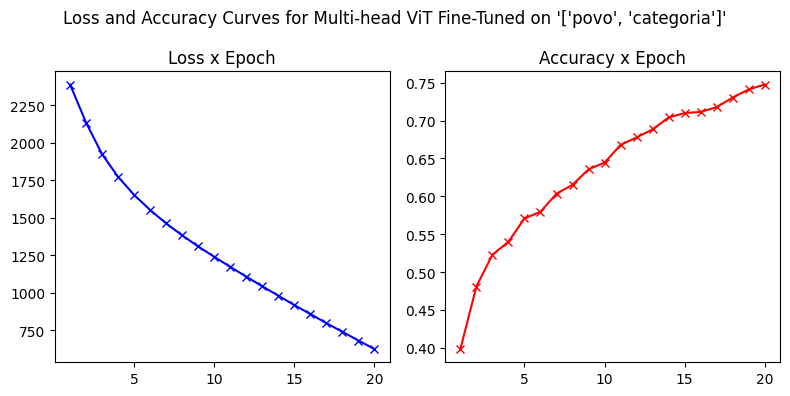

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/image_training_utils.py:718: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('dat

Validation 'povo' head accuracy: 0.6259765625
Validation 'categoria' head accuracy: 0.869140625
Validation average accuracy: 0.74755859375

Validation 'povo' head average per class precision: 0.6032
Validation 'povo' head average per class recall: 0.6085

Validation 'categoria' head average per class precision: 0.8516
Validation 'categoria' head average per class recall: 0.8663

Test 'povo' head accuracy: 0.6339755058288574
Test 'categoria' head accuracy: 0.8826619982719421
Test average accuracy: 0.75830078125

Test 'povo' head average per class precision: 0.6061
Test 'povo' head average per class recall: 0.6269

Test 'categoria' head average per class precision: 0.8746
Test 'categoria' head average per class recall: 0.8067



In [26]:
# Training multi-head model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = ViTClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=3e-6)
model_name = 'multihead_vit'
column_names = ['povo', 'categoria']
arch_name = 'ViT'
head_weights = [0.5, 0.5]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [27]:
# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

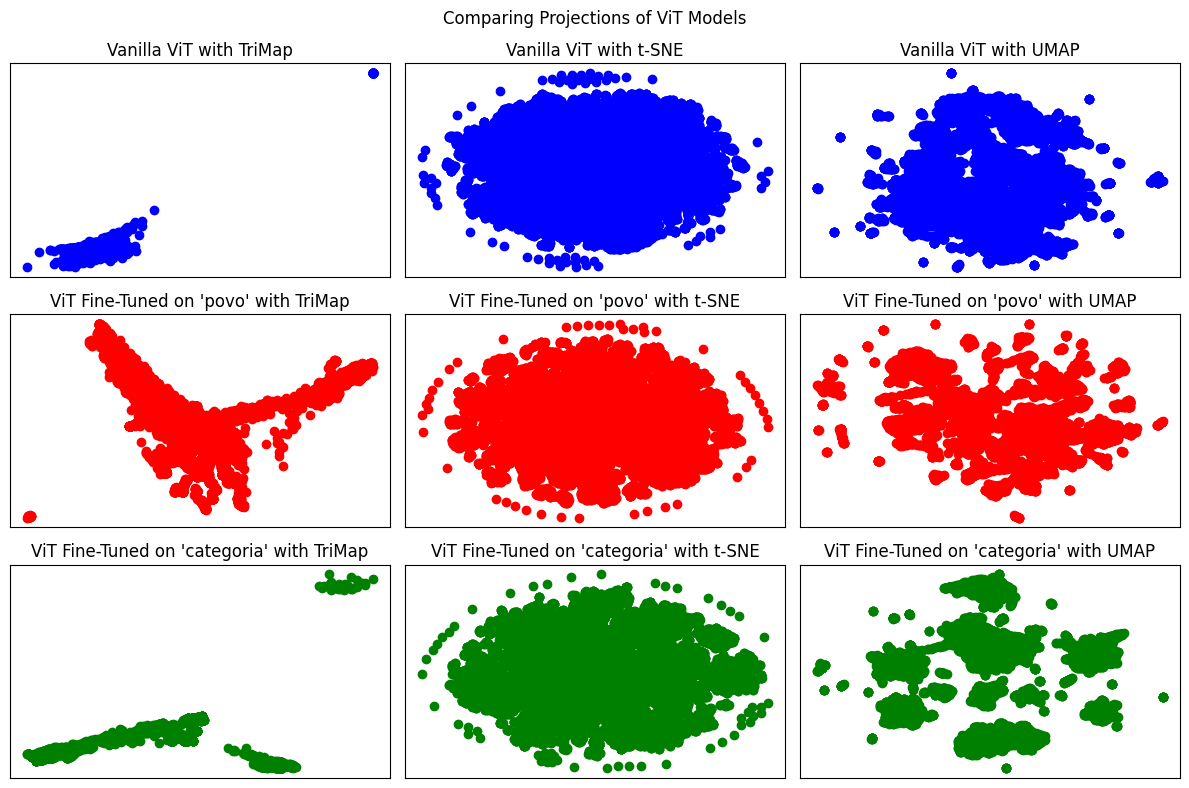

In [28]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=3, cols=3):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
projs = [vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap]
proj_names = ['Vanilla ViT with TriMap', 'Vanilla ViT with t-SNE', 'Vanilla ViT with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b')

# Plotting ViT fine-tuned on 'povo' projections
projs = [povo_vit_trimap, povo_vit_tsne, povo_vit_umap]
proj_names = ["ViT Fine-Tuned on 'povo' with TriMap", "ViT Fine-Tuned on 'povo' with t-SNE", \
              "ViT Fine-Tuned on 'povo' with UMAP"]
row_scatter_plot(projs, proj_names, 2, 'r')

# Plotting ViT fine-tuned on 'categoria' projections
projs = [categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap]
proj_names = ["ViT Fine-Tuned on 'categoria' with TriMap", \
              "ViT Fine-Tuned on 'categoria' with t-SNE", \
              "ViT Fine-Tuned on 'categoria' with UMAP"]
row_scatter_plot(projs, proj_names, 3, 'g')

# DECIDE IF I WANT TO PLOT FROZEN AND MULTI-HEAD MODELS' PROJECTIONS DEPENDING ON PERFORMANCE

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/image_training_utils.py:817: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


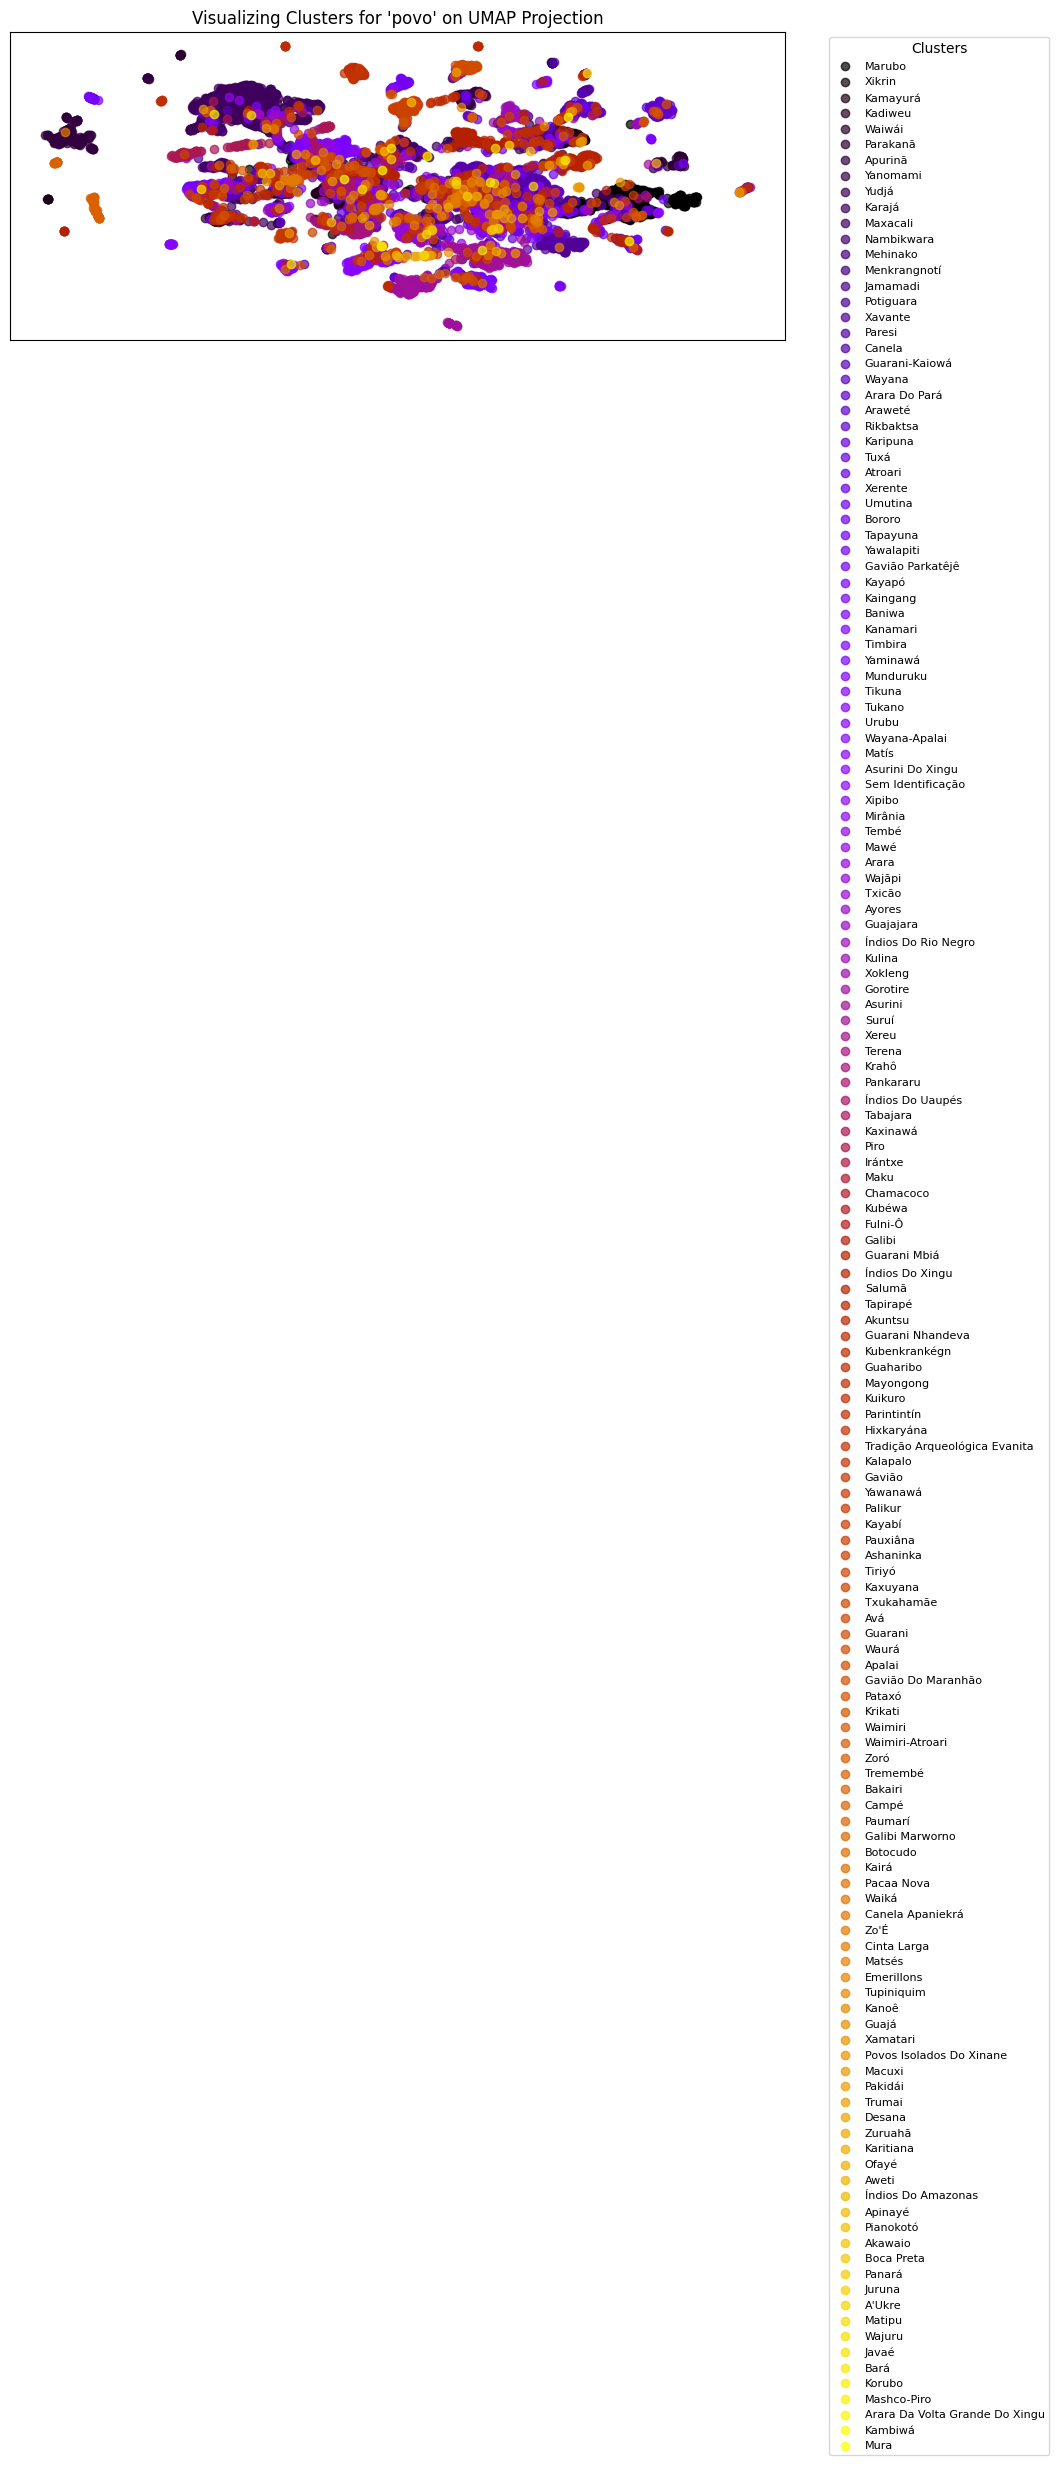

In [29]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

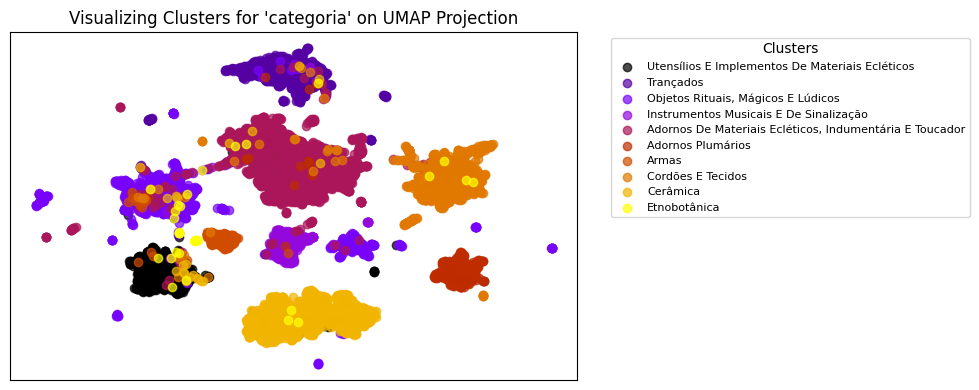

In [30]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

In [31]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
                   'povo_vit.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
                   categoria_image_indices, 'categoria', 'categoria_vit.csv')

## DINOv2

### Pre-Trained Embedding Space

In [32]:
from transformers import AutoImageProcessor, AutoModel

# Rebuilding dataset with DINO transform and dataloader with smaller batch_size because of 
# the model's size
dino_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
povo_dataset = ImageDataset(povo_labels, transform=dino_transform, augment=False)
povo_dataloader = DataLoader(povo_dataset, batch_size=16, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Loading model and pre-processor
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.to(device)

# Projecting data onto the off-the-shelf pre-trained embedding space from DINOv2
image_embeddings, _ = get_embeddings(model, povo_dataloader, device, model_name='dino')
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data reduced-dimensionality projections
_, _, vanilla_dino_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|███████████████████████████████████████| 705/705 [03:03<00:00,  3.83it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [33]:
# Creating our own DINO classifier head for fine-tuning
class DINOClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(DINOClassifier, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        self.classifier1 = nn.Linear(self.dino.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.dino.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)
    
    def forward(self, x):
        outputs = self.dino(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

Training model:   5%|██▎                                          | 1/20 [05:13<1:39:11, 313.25s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1752.1682, Validation Accuracy: 0.4414


Training model:  10%|████▌                                        | 2/20 [10:21<1:33:04, 310.25s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1099.6152, Validation Accuracy: 0.5133


Training model:  15%|██████▊                                      | 3/20 [15:30<1:27:42, 309.57s/it]

Best model saved at epoch 3
Epoch 3, Loss: 619.3794, Validation Accuracy: 0.5941


Training model:  20%|█████████                                    | 4/20 [20:38<1:22:25, 309.08s/it]

Best model saved at epoch 4
Epoch 4, Loss: 265.2686, Validation Accuracy: 0.6089


Training model:  25%|███████████▎                                 | 5/20 [25:37<1:16:22, 305.47s/it]

Best model saved at epoch 5
Epoch 5, Loss: 105.4268, Validation Accuracy: 0.6276


Training model:  30%|█████████████▌                               | 6/20 [30:35<1:10:39, 302.81s/it]

Epoch 6, Loss: 65.3477, Validation Accuracy: 0.6187


Training model:  35%|███████████████▋                             | 7/20 [35:33<1:05:16, 301.25s/it]

Epoch 7, Loss: 53.7010, Validation Accuracy: 0.6187


Training model:  40%|██████████████████                           | 8/20 [40:31<1:00:04, 300.41s/it]

Epoch 8, Loss: 92.8529, Validation Accuracy: 0.6049


Training model:  45%|█████████████████████▏                         | 9/20 [45:36<55:20, 301.88s/it]

Epoch 9, Loss: 49.6472, Validation Accuracy: 0.6010


Training model:  45%|████████████████████▎                        | 9/20 [50:45<1:02:02, 338.43s/it]

Early-stopping training!


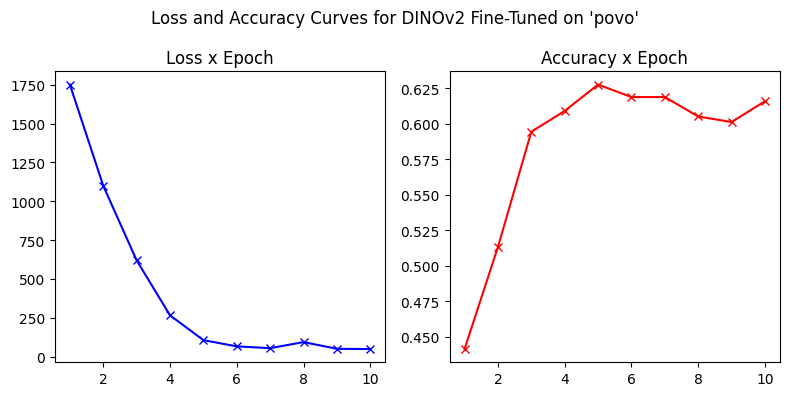

Validation accuracy: 0.62744140625
Validation average per class precision: 0.2554
Validation average per class recall: 0.2329

Test accuracy: 0.6637089848518372
Test average per class precision: 0.3071
Test average per class recall: 0.2809

Test average precision on filtered classes: 0.5779098574167643
Test average recall on filtered classes: 0.5442830736820514


In [39]:
# Recreating datasets for proper training and testing
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=dino_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=dino_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'dino_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                        batch_size, epochs, num_classes, model, criterion, \
                                        opt, model_name, column_name, \
                                        architecture_name='DINOv2')
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

In [40]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            dino_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

Training model:   5%|██▎                                          | 1/20 [08:46<2:46:35, 526.06s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1493.3237, Validation Accuracy: 0.5806


Training model:  10%|████▌                                        | 2/20 [17:29<2:37:24, 524.72s/it]

Best model saved at epoch 2
Epoch 2, Loss: 304.6301, Validation Accuracy: 0.6792


Training model:  15%|██████▊                                      | 3/20 [26:12<2:28:26, 523.93s/it]

Epoch 3, Loss: 115.8745, Validation Accuracy: 0.6651


Training model:  20%|█████████                                    | 4/20 [34:54<2:19:31, 523.23s/it]

Epoch 4, Loss: 111.0194, Validation Accuracy: 0.6714


Training model:  25%|███████████▎                                 | 5/20 [43:39<2:10:57, 523.84s/it]

Best model saved at epoch 5
Epoch 5, Loss: 63.9666, Validation Accuracy: 0.6948


Training model:  30%|█████████████▌                               | 6/20 [52:11<2:01:15, 519.70s/it]

Epoch 6, Loss: 90.2813, Validation Accuracy: 0.6197


Training model:  35%|███████████████                            | 7/20 [1:00:27<1:50:53, 511.77s/it]

Epoch 7, Loss: 49.2923, Validation Accuracy: 0.6588


Training model:  35%|███████████████                            | 7/20 [1:08:44<2:07:39, 589.16s/it]


Early-stopping training!


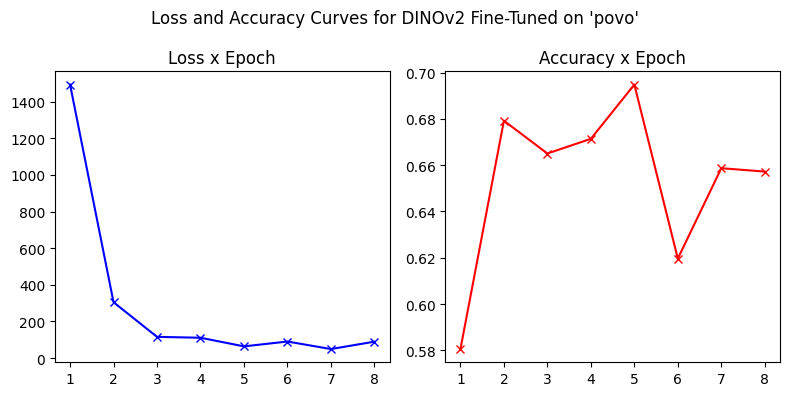

Validation accuracy: 0.69482421875
Validation average per class precision: 0.7158
Validation average per class recall: 0.6528



/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/image_training_utils.py:686: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('dat

Test accuracy: 0.7195122241973877
Test average per class precision: 0.7125
Test average per class recall: 0.6741



Computing embeddings:   0%|                                                 | 0/705 [00:00<?, ?it/s]


AttributeError: 'DINOClassifier' object has no attribute 'vit'

In [41]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                   device, 'dino')

# Cleaning up memory
clean_mem([model])

In [43]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = DINOClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, povo_balanced_val_dataset, architecture_name='DINOv2')

# Cleaning up memory
clean_mem([model])

Training model:   0%|                                                        | 0/20 [00:00<?, ?it/s]


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

#### *categoria* Column

In [ ]:
# Now creating the 'categoria' dataset
categoria_dataset = ImageDataset(categoria_labels, transform=dino_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=8, shuffle=True, \
                                  num_workers=0, pin_memory=True)

# Recreating datasets for proper training and testing
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=dino_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, transform=dino_transform, \
                                      augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'dino_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name, \
                                         architecture_name='DINOv2')
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, dino_transform, \
                               threshold_multiplier, 'categoria')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
categoria_dino_umap, categoria_image_indices = \
compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = DINOClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

In [44]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         dino_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

In [45]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

In [46]:
import image_training_utils
importlib.reload(image_training_utils)
from image_training_utils import *

# Training multi-head model on balanced dataset to see the difference in results
batch_size = 8
epochs = 20
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = DINOClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'multihead_dino'
column_names = ['povo', 'categoria']
arch_name = 'DINOv2'
head_weights = [0.5, 0.5]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

# Cleaning up memory
clean_mem([model])

Training model:   0%|                                                        | 0/20 [05:41<?, ?it/s]


KeyboardInterrupt: 

### Visualizing and Comparing Projections

In [ ]:
# Normalizing data for later plot on tool
vanilla_dino_umap = normalize(vanilla_dino_umap, norm_factor)
povo_dino_umap = normalize(povo_dino_umap, norm_factor)
categoria_dino_umap = normalize(categoria_dino_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing ViT and DINO Projections')

# Plotting all ViT projections
projs = [vanilla_vit_umap, povo_vit_umap, categoria_vit_umap]
proj_names = ["Vanilla ViT", "'povo' ViT", "'categoria' ViT"]
row_scatter_plot(projs, proj_names, 1, 'b', 2, 3)

# Plotting all DINO projections
projs = [vanilla_dino_umap, povo_dino_umap, categoria_dino_umap]
proj_names = ["Vanilla DINO", "'povo' DINO", "'categoria' DINO"]
row_scatter_plot(projs, proj_names, 2, 'r', 2, 3)

plt.tight_layout()
plt.show()